In [1]:
import torch
import pandas as pd
import numpy as np
import yaml
import importlib
import sys
import os
import matplotlib.pyplot as plt
import glob
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
import warnings
stf_dir = os.path.join(os.pardir, 'spacetimeformer')

sys.path.append(stf_dir)


import spacetimeformer as stf
importlib.reload(stf) #to make sure the last version of stf is used

from torch.distributions import Normal
import pickle

In [2]:
os.listdir("..\\spacetimeformer\\spacetimeformer\\data\\stf_LOG_DIR\\wandb\\")

['run-20220309_144454-tq5nzspb',
 'run-20220309_145450-3nzjwnv9',
 'run-20220309_160528-dncdoo7o',
 'run-20220309_162332-1wvm6y6m',
 'run-20220309_162357-142148s6',
 'run-20220309_163828-1p01uoj3',
 'run-20220309_175332-1zbkkp2a',
 'run-20220309_175357-16nfo94h',
 'run-20220309_180329-3foofrtb',
 'run-20220310_133006-gxxfap3n',
 'run-20220310_134344-2wrqohoq',
 'run-20220311_143155-1qph7vgp',
 'run-20220311_143213-3camjv6f',
 'run-20220311_143924-3asnwyy9',
 'run-20220311_144132-3fwfsn6w',
 'run-20220311_145607-3ficlwez',
 'run-20220311_171546-3gxv9qle',
 'run-20220311_174834-ym4uvfpv',
 'run-20220311_174915-3pwi5dx8',
 'run-20220311_175054-32lr4vqw',
 'run-20220314_090524-14ssgdk9',
 'run-20220314_092703-2vahwf14',
 'run-20220314_092732-1uhy3tbv',
 'run-20220314_092812-156pzr5x',
 'run-20220314_132645-2tdi8anz',
 'run-20220314_132715-1vlskdzo',
 'run-20220315_103112-3nbf1la4',
 'run-20220315_103139-2kfujejz',
 'run-20220315_105704-26gojq82',
 'run-20220315_110033-6g39nco2',
 'run-2022

In [289]:
'''#lstm_1_day_forecast_cyanochla
run_names = ['run-20220414_140439-3gftvviu', #fold 4
             'run-20220414_143813-1joxekzi', #fold 3
             'run-20220414_151324-3kt91dit', #fold 2
             'run-20220414_163024-e50mqup8', #fold 1
             'run-20220414_164744-14ts2nmq'] #fold 0
             '''
'''
#15_days_pred_cyanochla_small
run_names=[  'run-20220421_092743-3kfgcace', #fold 9
             'run-20220421_100142-20h0ln6b', #fold 8
             'run-20220421_104159-1wnwyiw4', #fold 7
             'run-20220421_105526-glu4yn6r', #fold 6
             'run-20220421_110704-14i1crey', #fold 5
             'run-20220421_112151-om5e5jmh', #fold 4
             'run-20220421_114003-3o9f257q', #fold 3
             'run-20220421_120953-3fdp0nzt', #fold 2
             'run-20220421_122244-hkduw4k9', #fold 1
             'run-20220421_123814-3jnpo6kt'] #fold 0
'''
#30_days_pred_cyanochla_less_small
run_names=[ 'run-20220421_131548-36mneh49',
             'run-20220421_134959-3izx5sk5',
             'run-20220421_140940-28ev888f',
             'run-20220421_142746-2ke8mi51',
             'run-20220421_144104-1pduz55n',
             'run-20220421_145721-77ibv141',
             'run-20220421_151957-tzl3fzrq',
             'run-20220421_155200-1wi6muy1',
             'run-20220421_161816-1u6lanom',
            'run-20220421_163852-2ocggok7'] #fold 0
            
run_name = run_names[0]
config_path = "..\\spacetimeformer\\spacetimeformer\\data\\stf_LOG_DIR\\wandb\\" + run_name+"\\files\\config.yaml"
with open(config_path) as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    config = yaml.load(file, Loader=yaml.FullLoader)
config_pross = {}
for key in config:
    try:
        config_pross[key]=config[key]['value']
    except:
        config_pross[key]=config[key]
config=config_pross
print("run name: "+config['run_name'])
print("model used: "+config['model'])
print("dataset used: "+config['dset'])
print("fold: "+str(config['fold_val']))

run name: 30_days_pred_cyanochla_less_small
model used: lstm
dataset used: HF_int4
fold: 9


In [290]:
#build the dset

if config['dset'] =='HF_int' or config['dset'] == 'HF_noint' or config['dset'] == 'HF_int4':
    data_path = config['data_path']
    date_format = "%Y-%m-%d %H:%M:%S"
    if data_path == 'auto':
        if config['dset'] =='HF_int':
            data_path = "../Datasets/Forecasting_Aqua/data_h_rolling_cst_int.csv"
        if config['dset'] == 'HF_noint':
            data_path = "../Datasets/Forecasting_Aqua/data_h_rolling_v4.csv"
        if config['dset'] == 'HF_int4':
            data_path = "../Datasets/Forecasting_Aqua/data_h_rolling_interpolated_v4.csv"
    df = pd.read_csv(data_path)
    target_cols = ['mean_chla_depth','aphanizomenon']
    target_cols+=list(df.keys().drop(['Datetime','mean_chla_depth','aphanizomenon']))
    NULL_VAL = 0.
        
dset = stf.data.CSVTimeSeriesV2(
    data_path=data_path,
    target_cols=target_cols,
    date_format = date_format,
    nanval = NULL_VAL,
    folds = config['folds'],
    fold_n = config['fold_val'],
)

x_dim = 4 if 'HF' in config['dset'] else 3
y_dim = len(target_cols)
loss_w = torch.zeros(y_dim)
loss_w[0] = 1
loss_w /=loss_w.sum()

#build the model

if config['model'] == "lstm":
    forecaster = stf.lstm_model.LSTM_Forecaster(
        # encoder
        d_x=x_dim,
        d_y=y_dim,
        time_emb_dim=config['time_emb_dim'],
        hidden_dim=config['hidden_dim'],
        n_layers=config['n_layers'],
        dropout_p=config['dropout_p'],
        # training
        learning_rate=config['learning_rate'],
        teacher_forcing_prob=config['teacher_forcing_start'],
        l2_coeff=config['l2_coeff'],
        loss=config['loss'],
        linear_window=config['linear_window'],
    )
else:
    print(f"{config['model']} model not implemented")


In [291]:
config['folds']

10

In [292]:
#load the checkpoints
checkpoints_dir = "..\\spacetimeformer\\data\\stf_model_checkpoints\\"
run_name = config['run_name']

checkpoints = glob.glob(checkpoints_dir+run_name+"_"+"*\\*\\*",recursive=True)
checkpoint = checkpoints[-config['fold_val']]
checkpoints

['..\\spacetimeformer\\data\\stf_model_checkpoints\\30_days_pred_cyanochla_less_small_038912352\\30_days_pred_cyanochla_less_smallepoch=02-val\\loss=0.00.ckpt',
 '..\\spacetimeformer\\data\\stf_model_checkpoints\\30_days_pred_cyanochla_less_small_093721315\\30_days_pred_cyanochla_less_smallepoch=00-val\\loss=0.00.ckpt',
 '..\\spacetimeformer\\data\\stf_model_checkpoints\\30_days_pred_cyanochla_less_small_106516225\\30_days_pred_cyanochla_less_smallepoch=08-val\\loss=0.00.ckpt',
 '..\\spacetimeformer\\data\\stf_model_checkpoints\\30_days_pred_cyanochla_less_small_176838139\\30_days_pred_cyanochla_less_smallepoch=01-val\\loss=0.00.ckpt',
 '..\\spacetimeformer\\data\\stf_model_checkpoints\\30_days_pred_cyanochla_less_small_400803870\\30_days_pred_cyanochla_less_smallepoch=00-val\\loss=0.00.ckpt',
 '..\\spacetimeformer\\data\\stf_model_checkpoints\\30_days_pred_cyanochla_less_small_531096461\\30_days_pred_cyanochla_less_smallepoch=00-val\\loss=0.01.ckpt',
 '..\\spacetimeformer\\data\\stf_m

In [293]:
forecaster.load_state_dict(torch.load(checkpoint)['state_dict'],strict=True)

<All keys matched successfully>

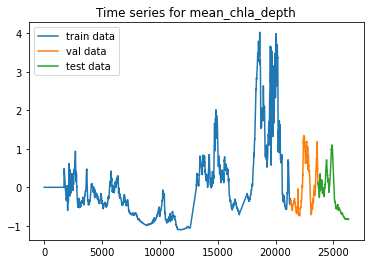

In [294]:
key = 'mean_chla_depth'
y_train = dset.train_data[key]
y_val = dset.val_data[key]
y_test = dset.test_data[key]
plt.plot(dset.train_data.index,y_train)
plt.plot(dset.val_data.index,y_val)
plt.plot(dset.test_data.index,y_test)
plt.title(f"Time series for {key}")
plt.legend(["train data","val data","test data"])
plt.show()

In [295]:
#format the dataset into x and y:
x_train = (dset.train_data[['Day','Month','Year','Hour']] if 'HF' in config['dset'] 
           else dset.train_data[['Day','Month','Year']])
y_train = dset.train_data[target_cols]

x_val = (dset.val_data[['Day','Month','Year','Hour']] if 'HF' in config['dset'] 
        else dset.val_data[['Day','Month','Year']])
y_val = dset.val_data[target_cols]

x_test = (dset.test_data[['Day','Month','Year','Hour']] if 'HF' in config['dset'] 
          else dset.test_data[['Day','Month','Year']])
y_test = dset.test_data[target_cols]

In [296]:
#predict all results
res = {}
true = {}
ctx = config['context_points']
trg = config['target_points']
time_res_ctx = config['time_resolution_ctx']
time_res_trg = config['time_resolution_trg']

batch_size = 100

def generate_batch(list_of_tuple, batch_size):
    if batch_size<=0:
        return
    for i in range(0, len(list_of_tuple), batch_size):
        yield (torch.cat([el[0].unsqueeze(0) for el in list_of_tuple[i : i + batch_size]]),
               torch.cat([el[1].unsqueeze(0) for el in list_of_tuple[i : i + batch_size]]),
               torch.cat([el[2].unsqueeze(0) for el in list_of_tuple[i : i + batch_size]]),
               torch.cat([el[3].unsqueeze(0) for el in list_of_tuple[i : i + batch_size]]),
              )
        
        
for x,y,split in [(x_train,y_train,'train'),(x_val,y_val,'val'),(x_test,y_test,'test')]:
    x = torch.tensor(x.values,dtype=torch.float32)
    y = torch.tensor(y.values,dtype=torch.float32)
    res[split]=[]
    true[split]=[]
    print(f"split: {split}      ")
    
        
    if (len(dset.idxbreaks)==2 or split != 'train'):
        slice_start = [i for i in range(0,
                                       (dset.length(split)
                                       - time_res_trg * trg
                                       - time_res_ctx * ctx),
                                       )
                                ]
    else:
        slice_start = [i for i in range(0,
                                       (dset.idxbreaks[0]
                                       - time_res_trg * trg
                                       - time_res_ctx * ctx),
                                       )
                                ]
        slice_start+= [i for i in range(dset.idxbreaks[0],
                                       (dset.length(split)
                                       - time_res_trg * trg
                                       - time_res_ctx * ctx),
                                       )
                                ]
    #build slices:
    input_list = []
    for idx in slice_start:
        x_ctx = x[idx:idx+ctx*time_res_ctx:time_res_ctx]
        x_trg = x[idx+ctx*time_res_ctx + time_res_trg-time_res_ctx :
                  idx+ctx*time_res_ctx + time_res_trg-time_res_ctx + trg*time_res_trg:
                  time_res_trg]
        y_ctx = y[idx:idx+ctx*time_res_ctx:time_res_ctx]
        y_trg = y[idx+ctx*time_res_ctx + time_res_trg-time_res_ctx :
                  idx+ctx*time_res_ctx + time_res_trg-time_res_ctx + trg*time_res_trg:
                  time_res_trg]
        input_list.append((x_ctx,y_ctx,x_trg,y_trg))
        
    gen = generate_batch(input_list, batch_size)
    
    for idx,(x_ctx,y_ctx,x_trg,y_trg) in enumerate(gen):
        print(f"{idx+1}/{len(input_list)/batch_size}",end='\r')
        with torch.no_grad():
            res_idx,*class_res=forecaster(x_ctx,y_ctx,x_trg,y_trg,**forecaster.eval_step_forward_kwargs)
            if isinstance(res_idx,Normal):
                res[split].append(res_idx.loc.squeeze())
            else:
                res[split].append(res_idx)
                true[split].append(y_trg)


split: train      
split: val      
split: test      


In [297]:
# only keep the usefull columns:
res_target = {}
true_target = {}
for split in ['train','val','test']:
    res_target[split]= torch.cat(res[split])[:,:,:len(config['loss_w'])]
    true_target[split]=torch.cat(true[split])[:,:,:len(config['loss_w'])]

In [298]:
dset.idxbreaks

[21307, 23674]

In [305]:
torch.cat([el for el in true['val']])[:,:,1].mean()

tensor(11.5573)

In [303]:
y_val['aphanizomenon'].mean()

7.640104892296236

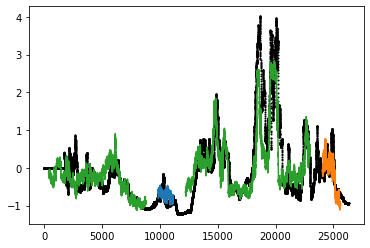

In [171]:
#for prediction:
key = 'mean_chla_depth'
#key = 'aphanizomenon'
key_lag = 1
idx = target_cols.index(key)

context_span = ctx*time_res_ctx
tot_pred_span = trg*time_res_trg
past_pred_span = key_lag*time_res_trg
next_pred_span = (trg-key_lag)*time_res_trg
for data,split in zip([dset.train_data,dset.val_data,dset.test_data],['train','val','test']):
    if split == 'train':
        
        plt.plot(data.index[context_span+past_pred_span:
                            dset.idxbreaks[0]-next_pred_span],
                 res_target[split][:dset.idxbreaks[0]-context_span-tot_pred_span,key_lag-1,idx],
                 color='tab:green')
        
        plt.plot(data.index[dset.idxbreaks[0]+context_span+past_pred_span:
                            len(data)-next_pred_span],
                 res_target[split][dset.idxbreaks[0]-context_span-tot_pred_span:
                                    len(data)-next_pred_span,key_lag-1,idx],
                 color='tab:green')
    else:
        
        plt.plot(data.index[context_span+past_pred_span:len(data)-next_pred_span],
                 res_target[split][:,key_lag-1,idx])
    plt.scatter(data.index,data[key],s=1,c='k')
    #plt.scatter(dset.val_data.index,dset.val_data[key],s=1)
    
    #plt.scatter((data.index+(ctx-1)*time_res_ctx+time_res_trg)[:len(res_target[split])],res_target[split][:,0,idx],s=1)
    #plt.scatter((data.index+(ctx-1)*time_res_ctx+time_res_trg)[:len(res_target[split])],true_target[split][:,0,idx],s=1)


In [172]:
#R2:
keys= ['mean_chla_depth','aphanizomenon']

for key in keys:
    idx = target_cols.index(key)
    print(f"Score for {key}")
    for split in ['train','val','test']:
        r2 =1-(torch.sum(torch.square(true_target[split][...,idx]-res_target[split][...,idx]))/
               torch.sum(torch.square(true_target[split][...,idx]-true_target[split][...,idx].mean())))
        print(f"Nash score for the {split}: {r2}")

Score for mean_chla_depth
Nash score for the train: 0.4336444139480591
Nash score for the val: -0.11796808242797852
Nash score for the test: 0.3182153105735779
Score for aphanizomenon
Nash score for the train: -0.22007930278778076
Nash score for the val: -34.996463775634766
Nash score for the test: -186.80157470703125


## K-Fold validation:

In [306]:
res_fold = []
true_fold = []
for run in run_names:
    config_path = "..\\spacetimeformer\\spacetimeformer\\data\\stf_LOG_DIR\\wandb\\" + run+"\\files\\config.yaml"
    with open(config_path) as file:
        # The FullLoader parameter handles the conversion from YAML
        # scalar values to Python the dictionary format
        config = yaml.load(file, Loader=yaml.FullLoader)
    config_pross = {}
    for key in config:
        try:
            config_pross[key]=config[key]['value']
        except:
            config_pross[key]=config[key]
    config=config_pross
    print("run name: "+config['run_name'])
    print("model used: "+config['model'])
    print("dataset used: "+config['dset'])
    print("fold: "+str(config['fold_val']))
    
    
    #rebuild the dataset for each fold
    if config['dset'] =='HF_int' or config['dset'] == 'HF_noint' or config['dset'] == 'HF_int4':
        data_path = config['data_path']
        date_format = "%Y-%m-%d %H:%M:%S"
        if data_path == 'auto':
            if config['dset'] =='HF_int':
                data_path = "../Datasets/Forecasting_Aqua/data_h_rolling_cst_int.csv"
            if config['dset'] == 'HF_noint':
                data_path = "../Datasets/Forecasting_Aqua/data_h_rolling_v4.csv"
            if config['dset'] == 'HF_int4':
                data_path = "../Datasets/Forecasting_Aqua/data_h_rolling_interpolated_v4.csv"
        df = pd.read_csv(data_path)
        target_cols = ['mean_chla_depth','aphanizomenon']
        target_cols+=list(df.keys().drop(['Datetime','mean_chla_depth','aphanizomenon']))
        NULL_VAL = 0.

    dset = stf.data.CSVTimeSeriesV2(
        data_path=data_path,
        target_cols=target_cols,
        date_format = date_format,
        nanval = NULL_VAL,
        folds = config['folds'],
        fold_n = config['fold_val'],
    )
    # use the same model as previously defined,and
    #load the checkpoints
    checkpoints_dir = "..\\spacetimeformer\\data\\stf_model_checkpoints\\"
    run_name = config['run_name']
    salt = ""

    checkpoints = glob.glob(checkpoints_dir+run_name+"_"+salt+"*\\*\\*",recursive=True)
    checkpoint = checkpoints[config['folds']-config['fold_val']-1]
    #checkpoint = checkpoints[config['fold_val']]
    forecaster.load_state_dict(torch.load(checkpoint)['state_dict'],strict=True)
    
    #format the dataset into x and y:
    x_val = (dset.val_data[['Day','Month','Year','Hour']] if 'HF' in config['dset'] 
            else dset.val_data[['Day','Month','Year']])
    y_val = dset.val_data[target_cols]

    x_test = (dset.test_data[['Day','Month','Year','Hour']] if 'HF' in config['dset'] 
              else dset.test_data[['Day','Month','Year']])
    y_test = dset.test_data[target_cols]
    
    
    #predict all results
    res = {'fold':config['fold_val']}
    true = {'fold':config['fold_val']}
    ctx = config['context_points']
    trg = config['target_points']
    time_res_ctx = config['time_resolution_ctx']
    time_res_trg = config['time_resolution_trg']

    batch_size = 100
    
    for x,y,split in [(x_val,y_val,'val'),(x_test,y_test,'test')]:
        x = torch.tensor(x.values,dtype=torch.float32)
        y = torch.tensor(y.values,dtype=torch.float32)
        res[split]=[]
        true[split]=[]
        print(f"split: {split}      ")


        slice_start = [i for i in range(0,
                                       (dset.length(split)
                                       - time_res_trg * trg
                                       - time_res_ctx * ctx),
                                       )
                                ]

        #build slices:
        input_list = []
        for idx in slice_start:
            x_ctx = x[idx:idx+ctx*time_res_ctx:time_res_ctx]
            x_trg = x[idx+ctx*time_res_ctx + time_res_trg-time_res_ctx :
                      idx+ctx*time_res_ctx + time_res_trg-time_res_ctx + trg*time_res_trg:
                      time_res_trg]
            y_ctx = y[idx:idx+ctx*time_res_ctx:time_res_ctx]
            y_trg = y[idx+ctx*time_res_ctx + time_res_trg-time_res_ctx :
                      idx+ctx*time_res_ctx + time_res_trg-time_res_ctx + trg*time_res_trg:
                      time_res_trg]
            input_list.append((x_ctx,y_ctx,x_trg,y_trg))

        gen = generate_batch(input_list, batch_size)

        for idx,(x_ctx,y_ctx,x_trg,y_trg) in enumerate(gen):
            print(f"{idx+1}/{len(input_list)/batch_size}",end='\r')
            with torch.no_grad():
                res_idx,*class_res=forecaster(x_ctx,y_ctx,x_trg,y_trg,**forecaster.eval_step_forward_kwargs)
                if isinstance(res_idx,Normal):
                    res[split].append(res_idx.loc.squeeze())
                else:
                    res[split].append(res_idx)
                    true[split].append(y_trg)
    res_fold.append(res)
    true_fold.append(true)

run name: 30_days_pred_cyanochla_less_small
model used: lstm
dataset used: HF_int4
fold: 9
split: val      
split: test      
run name: 30_days_pred_cyanochla_less_small
model used: lstm
dataset used: HF_int4
fold: 8
split: val      
split: test      
run name: 30_days_pred_cyanochla_less_small
model used: lstm
dataset used: HF_int4
fold: 7
split: val      
split: test      
run name: 30_days_pred_cyanochla_less_small
model used: lstm
dataset used: HF_int4
fold: 6
split: val      
split: test      
run name: 30_days_pred_cyanochla_less_small
model used: lstm
dataset used: HF_int4
fold: 5
split: val      
split: test      
run name: 30_days_pred_cyanochla_less_small
model used: lstm
dataset used: HF_int4
fold: 4
split: val      
split: test      
run name: 30_days_pred_cyanochla_less_small
model used: lstm
dataset used: HF_int4
fold: 3
split: val      
split: test      
run name: 30_days_pred_cyanochla_less_small
model used: lstm
dataset used: HF_int4
fold: 2
split: val      
split: tes

In [311]:
len(input_list)

1550

In [312]:
true_target['val'][-1,0,1]

tensor(0.)

In [313]:
res_target['val'][-1,0,1]

tensor(-0.1833)

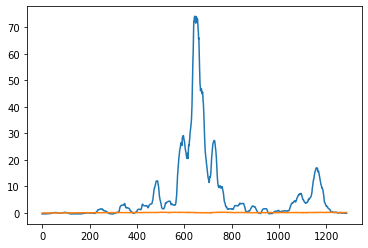

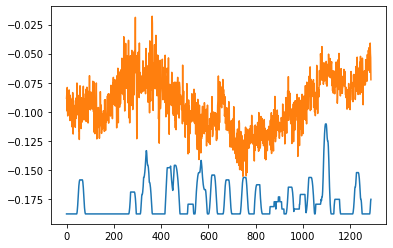

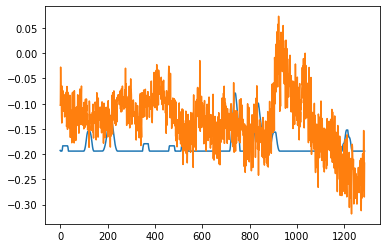

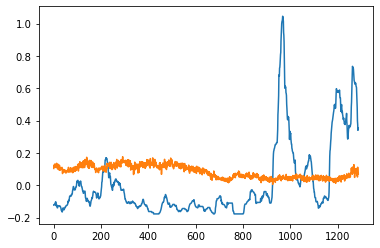

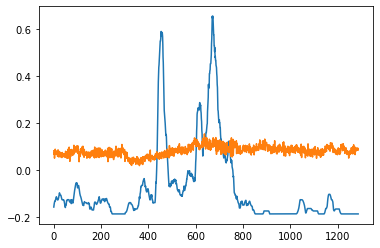

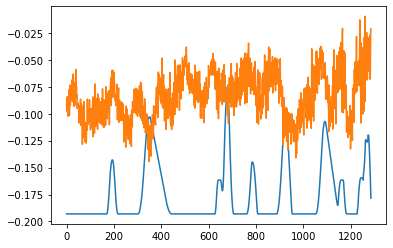

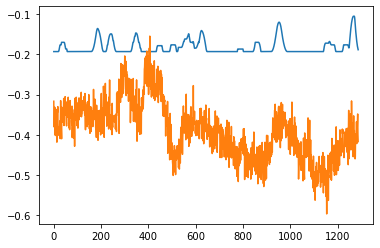

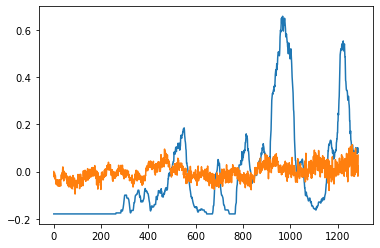

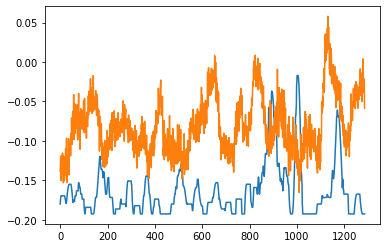

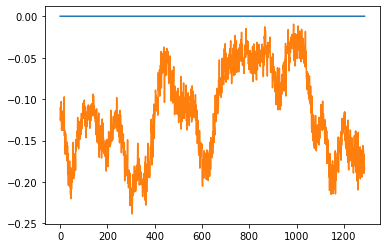

In [314]:
idx = 1
lag_to_plot = 0
for res,true in zip(res_fold,true_fold):
    for split in ['val','test']:
        res_target[split]= torch.cat(res[split])[:,:,:len(config['loss_w'])]
        true_target[split]=torch.cat(true[split])[:,:,:len(config['loss_w'])]
    
    plt.plot(true_target['val'][:,lag_to_plot,idx])
    plt.plot(res_target['val'][:,lag_to_plot,idx])
    plt.show()

In [315]:
res_fold[0]['val'][0].shape

torch.Size([100, 30, 102])

In [316]:
true_target['val'].shape

torch.Size([1288, 30, 2])

In [317]:
keys= ['mean_chla_depth','aphanizomenon']
r2_d = {}
for key in keys:
    idx = target_cols.index(key)
    r2_d[key]=[]
    print(f"Score for {key}")
    for idx_fold,(res,true) in enumerate(zip(res_fold,true_fold)):
        r2_split = {}
        for split in ['val','test']:
            res_target[split]= torch.cat(res[split])[:,:,:len(config['loss_w'])]
            true_target[split]=torch.cat(true[split])[:,:,:len(config['loss_w'])]
            r2 =1-(torch.sum(torch.square(true_target[split][...,idx]-res_target[split][...,idx]))/
                   torch.sum(torch.square(true_target[split][...,idx]-true_target[split][...,idx].mean())))
            
            print(f"Nash score for the {split}: {r2}")
            r2_split[split]=r2
        r2_d[key].append(r2_split)

Score for mean_chla_depth
Nash score for the val: -0.4306377172470093
Nash score for the test: 0.2847839593887329
Nash score for the val: -1.2074944972991943
Nash score for the test: 0.0036926865577697754
Nash score for the val: -0.20946455001831055
Nash score for the test: 0.34387320280075073
Nash score for the val: -0.6302140951156616
Nash score for the test: -0.00766444206237793
Nash score for the val: -0.030196547508239746
Nash score for the test: -0.16872119903564453
Nash score for the val: -12.832036018371582
Nash score for the test: -0.12973105907440186
Nash score for the val: -3.5324811935424805
Nash score for the test: 0.3456485867500305
Nash score for the val: -0.16529130935668945
Nash score for the test: 0.09942668676376343
Nash score for the val: -1.0968976020812988
Nash score for the test: 0.01781761646270752
Nash score for the val: -5.345536708831787
Nash score for the test: 0.35228800773620605
Score for aphanizomenon
Nash score for the val: -0.27172887325286865
Nash scor

In [318]:
for key in keys:
    print(f"Validation R2 for {key}: {np.mean([el['val'] for el in r2_d[key]]):.2f} +/- {2*np.std([el['val'] for el in r2_d[key]]):.2f}")
    print(f"Test       R2 for {key}: {np.mean([el['test'] for el in r2_d[key]]):.2f} +/- {2*np.std([el['test'] for el in r2_d[key]]):.2f}")

Validation R2 for mean_chla_depth: -2.55 +/- 7.59
Test       R2 for mean_chla_depth: 0.11 +/- 0.38
Validation R2 for aphanizomenon: -17.27 +/- 57.25
Test       R2 for aphanizomenon: -22.89 +/- 81.51


In [319]:
#compute the global r2 for the validation
keys= ['mean_chla_depth','aphanizomenon']

res_glob= torch.cat([torch.cat(res['val'])[:,:,:len(config['loss_w'])] for res in res_fold])
true_glob=torch.cat([torch.cat(true['val'])[:,:,:len(config['loss_w'])] for true in true_fold])

r2_glob = 1- (torch.mean(torch.square(res_glob-true_glob),axis=0)/
              torch.mean(torch.square(torch.mean(true_glob, axis=0)-true_glob),axis=0))
print("Global r2 on the validations sets:")
for idx,key in enumerate(keys):
    print(f"{key}: {r2_glob[:,idx].mean():.2f}")

Global r2 on the validations sets:
mean_chla_depth: 0.07
aphanizomenon: -0.02


In [329]:
true_last = torch.cat(true_fold[0]['val'])[:,:,:len(config['loss_w'])]

In [330]:
true_last[:,:,1].mean()

tensor(11.5573)

In [328]:
#compute the score on each fold 
print("Global r2 on the validations sets:")
lag = 30
for idx,key in enumerate(keys):
    print(f"{key}: global: {r2_glob[lag-1,idx]:.2f}")
    for idx_fold,(res,true) in enumerate(zip(res_fold,true_fold)):
        res_loc = torch.cat([el for el in res['val']])[:,:,:len(config['loss_w'])]
        true_loc = torch.cat([el for el in true['val']])[:,:,:len(config['loss_w'])]
        r2_g_loc = 1- (torch.mean(torch.square(res_loc-true_loc),axis=0)/
                       torch.mean(torch.square(torch.mean(true_glob, axis=0)-true_loc),axis=0))
        print(f"r2 fold {9-idx_fold}: {r2_g_loc[lag-1,idx]:.2f}")

Global r2 on the validations sets:
mean_chla_depth: global: -0.12
r2 fold 9: -1.14
r2 fold 8: -0.09
r2 fold 7: -0.35
r2 fold 6: -0.06
r2 fold 5: -0.20
r2 fold 4: 0.27
r2 fold 3: 0.93
r2 fold 2: 0.52
r2 fold 1: -0.25
r2 fold 0: -6.67
aphanizomenon: global: -0.01
r2 fold 9: -0.03
r2 fold 8: 0.96
r2 fold 7: 0.98
r2 fold 6: 0.89
r2 fold 5: 0.96
r2 fold 4: 0.99
r2 fold 3: 0.99
r2 fold 2: 0.95
r2 fold 1: 0.98
r2 fold 0: 0.97


In [264]:
true_loc.shape

torch.Size([1288, 30, 2])

In [265]:
true_glob[:,0,1].std()

tensor(4.5650)

In [331]:
#compute the score on each fold 
print("Global r2 on the validations sets:")
lag = 30
for idx,key in enumerate(keys):
    print(f"{key}: global: {r2_glob[lag-1,idx]:.2f}")
    for idx_fold,(res,true) in enumerate(zip(res_fold,true_fold)):
        model_0 = torch.zeros_like(res_loc)
        true_loc = torch.cat([el for el in true['val']])[:,:,:len(config['loss_w'])]
        r2_g_loc = 1- (torch.mean(torch.square(true_loc),axis=0)/
                       torch.mean(torch.square(torch.mean(true_glob, axis=0)-true_loc),axis=0))
        print(f"r2 fold {9-idx_fold}: {r2_g_loc[lag-1,idx]:.2f}")

Global r2 on the validations sets:
mean_chla_depth: global: -0.12
r2 fold 9: -0.16
r2 fold 8: -0.07
r2 fold 7: -0.07
r2 fold 6: -0.00
r2 fold 5: -0.32
r2 fold 4: 0.19
r2 fold 3: 0.19
r2 fold 2: 0.41
r2 fold 1: 0.44
r2 fold 0: 0.22
aphanizomenon: global: -0.01
r2 fold 9: -0.03
r2 fold 8: 0.95
r2 fold 7: 0.97
r2 fold 6: 0.89
r2 fold 5: 0.97
r2 fold 4: 0.97
r2 fold 3: 0.97
r2 fold 2: 0.95
r2 fold 1: 0.97
r2 fold 0: 0.99


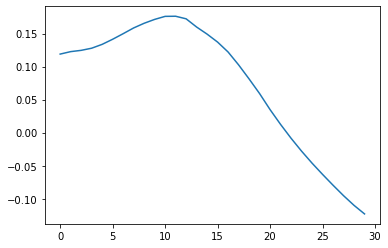

In [267]:
plt.plot(r2_glob[:,0])

In [200]:
keys= ['mean_chla_depth','aphanizomenon']

for key in keys:
    idx = target_cols.index(key)
    print(f"Score for {key}")
    for res,true in zip(res_fold,true_fold):
        for split in ['val','test']:
            res_target[split]= torch.cat(res[split])[:,:,:len(config['loss_w'])]
            true_target[split]=torch.cat(true[split])[:,:,:len(config['loss_w'])]
            r2 =1-(torch.sum(torch.square(true_target[split][...,idx]-res_target[split][...,idx]))/
                   torch.sum(torch.square(true_target[split][...,idx]-true_target[split][...,idx].mean())))
            print(f"Nash score for the {split}: {r2}")

Score for mean_chla_depth
Nash score for the val: -0.43039870262145996
Nash score for the test: 0.2841305732727051
Nash score for the val: -1.2074828147888184
Nash score for the test: 0.0035201311111450195
Nash score for the val: -0.2100893259048462
Nash score for the test: 0.3425357937812805
Nash score for the val: -0.6291537284851074
Nash score for the test: -0.007567644119262695
Nash score for the val: -0.03047502040863037
Nash score for the test: -0.168876051902771
Nash score for the val: -12.837156295776367
Nash score for the test: -0.12995946407318115
Nash score for the val: -3.5486464500427246
Nash score for the test: 0.34926778078079224
Nash score for the val: -0.16199994087219238
Nash score for the test: 0.09924215078353882
Nash score for the val: -1.1053876876831055
Nash score for the test: 0.01882028579711914
Nash score for the val: -5.291232585906982
Nash score for the test: 0.35515308380126953
Score for aphanizomenon
Nash score for the val: -0.27174925804138184
Nash score 